In [1]:
import os
import numpy as np
from matplotlib import pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy
from keras.applications import ResNet152V2, MobileNetV2, InceptionV3, VGG16
from tensorflow.keras.models import load_model
import cv2
import seaborn as sns
from sklearn.metrics import confusion_matrix
import pandas as pd

In [2]:
# Functions
def loss_acc_fig(history):
    fig = plt.figure(figsize = [20,7])
    fig.add_subplot(1,2,1); plt.plot(history.history['loss'], color='#2F70AF', label='loss'); plt.plot(history.history['val_loss'], color='#e77d01', label='val_loss'); plt.legend(loc="upper left"); plt.title('Loss', fontsize=20);
    fig.add_subplot(1,2,2); plt.plot(history.history['accuracy'], color='#724C9D', label='accuracy'); plt.plot(history.history['val_accuracy'], color='#FB7488', label='val_accuracy'); plt.legend(loc="upper left"); plt.title('Accuracy', fontsize=20);
    plt.show()
    
def ppv_tpr_acc_test(model):
    ppv = Precision()
    tpr = Recall()
    acc = BinaryAccuracy()
    for batch in test.as_numpy_iterator(): 
        x, y = batch
        yhat = model.predict(x)
        ppv.update_state(y, yhat)
        tpr.update_state(y, yhat)
        acc.update_state(y, yhat)
    print(ppv.result(), tpr.result(), acc.result())


def confusion_mat(model):
    df_comb = pd.DataFrame()
    for batch in test.as_numpy_iterator(): 
        x,y = batch
        yhat = model.predict(x)
        df = pd.DataFrame({'y': y.flatten(), 'yhat': yhat.flatten()})
        df_comb = pd.concat([df_comb, df])
    y_pred = [1 if x > 0.5 else 0 for x in df_comb.yhat]
    cf = confusion_matrix(df_comb.y, y_pred)
    print(cf)
    ax= plt.subplot()
    sns.heatmap(cf, annot=True, ax = ax);
    ax.set_xlabel('Predicted labels')
    ax.set_ylabel('True labels');
    ax.set_title('Confusion Matrix');
    ax.xaxis.set_ticklabels(['Crack', 'Potholes'])
    ax.yaxis.set_ticklabels(['Crack', 'Potholes'])

### Prevent OOM

In [3]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

In [ ]:
os.listdir()

### Data loading

In [5]:
train = tf.keras.utils.image_dataset_from_directory('road_images/split/train', batch_size=64, image_size=(224, 224)) 
train_iterator = train.as_numpy_iterator()
train_batch = train_iterator.next() 

dev = tf.keras.utils.image_dataset_from_directory('road_images/split/dev', batch_size=64, image_size=(224, 224)) 
dev_iterator = dev.as_numpy_iterator()
dev_batch = dev_iterator.next() 

test = tf.keras.utils.image_dataset_from_directory('road_images/split/test', batch_size=64, image_size=(224, 224)) 
test_iterator = test.as_numpy_iterator()
test_batch = test_iterator.next() 

Found 1946 files belonging to 2 classes.
Found 365 files belonging to 2 classes.
Found 122 files belonging to 2 classes.


### Data scaling

In [6]:
train = train.map(lambda x,y: (x/255, y))
dev = dev.map(lambda x,y: (x/255, y))
test = test.map(lambda x,y: (x/255, y))
test.as_numpy_iterator().next()

(array([[[[0.61736983, 0.6212914 , 0.64089924],
          [0.48199558, 0.48591715, 0.505525  ],
          [0.6972766 , 0.69816065, 0.7268809 ],
          ...,
          [0.8806952 , 0.8924599 , 0.92775404],
          [0.82153374, 0.83329844, 0.86859256],
          [0.7773317 , 0.7890964 , 0.82439053]],
 
         [[0.45785508, 0.46177664, 0.4813845 ],
          [0.5860207 , 0.5899423 , 0.6095501 ],
          [0.73800147, 0.73888564, 0.76760584],
          ...,
          [0.85024023, 0.86200494, 0.89729905],
          [0.7356151 , 0.7473798 , 0.7826739 ],
          [0.7930753 , 0.80484   , 0.84013414]],
 
         [[0.7747076 , 0.7786292 , 0.798237  ],
          [0.26072842, 0.26465   , 0.28425783],
          [0.7814321 , 0.7823162 , 0.8110364 ],
          ...,
          [0.8775507 , 0.8893154 , 0.92460954],
          [0.6210416 , 0.6328063 , 0.6681004 ],
          [0.82393086, 0.83569556, 0.8709897 ]],
 
         ...,
 
         [[0.31131172, 0.29562545, 0.28386074],
          [0.31742

### Modeling

### MobileNetv2

In [7]:
mobnet_conv = MobileNetV2(input_shape = (224,224,3), weights = 'imagenet', include_top = False)

In [8]:
mobnet_conv.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 112, 112, 32)         864       ['input_1[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 112, 112, 32)         128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 112, 112, 32)         0         ['bn_Conv1[

 block_3_expand_relu (ReLU)  (None, 56, 56, 144)          0         ['block_3_expand_BN[0][0]']   
                                                                                                  
 block_3_pad (ZeroPadding2D  (None, 57, 57, 144)          0         ['block_3_expand_relu[0][0]'] 
 )                                                                                                
                                                                                                  
 block_3_depthwise (Depthwi  (None, 28, 28, 144)          1296      ['block_3_pad[0][0]']         
 seConv2D)                                                                                        
                                                                                                  
 block_3_depthwise_BN (Batc  (None, 28, 28, 144)          576       ['block_3_depthwise[0][0]']   
 hNormalization)                                                                                  
          

 block_6_depthwise_BN (Batc  (None, 14, 14, 192)          768       ['block_6_depthwise[0][0]']   
 hNormalization)                                                                                  
                                                                                                  
 block_6_depthwise_relu (Re  (None, 14, 14, 192)          0         ['block_6_depthwise_BN[0][0]']
 LU)                                                                                              
                                                                                                  
 block_6_project (Conv2D)    (None, 14, 14, 64)           12288     ['block_6_depthwise_relu[0][0]
                                                                    ']                            
                                                                                                  
 block_6_project_BN (BatchN  (None, 14, 14, 64)           256       ['block_6_project[0][0]']     
 ormalizat

                                                                                                  
 block_9_add (Add)           (None, 14, 14, 64)           0         ['block_8_add[0][0]',         
                                                                     'block_9_project_BN[0][0]']  
                                                                                                  
 block_10_expand (Conv2D)    (None, 14, 14, 384)          24576     ['block_9_add[0][0]']         
                                                                                                  
 block_10_expand_BN (BatchN  (None, 14, 14, 384)          1536      ['block_10_expand[0][0]']     
 ormalization)                                                                                    
                                                                                                  
 block_10_expand_relu (ReLU  (None, 14, 14, 384)          0         ['block_10_expand_BN[0][0]']  
 )        

                                                                                                  
 block_13_expand_relu (ReLU  (None, 14, 14, 576)          0         ['block_13_expand_BN[0][0]']  
 )                                                                                                
                                                                                                  
 block_13_pad (ZeroPadding2  (None, 15, 15, 576)          0         ['block_13_expand_relu[0][0]']
 D)                                                                                               
                                                                                                  
 block_13_depthwise (Depthw  (None, 7, 7, 576)            5184      ['block_13_pad[0][0]']        
 iseConv2D)                                                                                       
                                                                                                  
 block_13_

 iseConv2D)                                                                                       
                                                                                                  
 block_16_depthwise_BN (Bat  (None, 7, 7, 960)            3840      ['block_16_depthwise[0][0]']  
 chNormalization)                                                                                 
                                                                                                  
 block_16_depthwise_relu (R  (None, 7, 7, 960)            0         ['block_16_depthwise_BN[0][0]'
 eLU)                                                               ]                             
                                                                                                  
 block_16_project (Conv2D)   (None, 7, 7, 320)            307200    ['block_16_depthwise_relu[0][0
                                                                    ]']                           
          

In [9]:
mobnet_conv.trainable = False

In [10]:
mobnet_conv.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 112, 112, 32)         864       ['input_1[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 112, 112, 32)         128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 112, 112, 32)         0         ['bn_Conv1[

 block_3_expand_relu (ReLU)  (None, 56, 56, 144)          0         ['block_3_expand_BN[0][0]']   
                                                                                                  
 block_3_pad (ZeroPadding2D  (None, 57, 57, 144)          0         ['block_3_expand_relu[0][0]'] 
 )                                                                                                
                                                                                                  
 block_3_depthwise (Depthwi  (None, 28, 28, 144)          1296      ['block_3_pad[0][0]']         
 seConv2D)                                                                                        
                                                                                                  
 block_3_depthwise_BN (Batc  (None, 28, 28, 144)          576       ['block_3_depthwise[0][0]']   
 hNormalization)                                                                                  
          

 block_6_depthwise_BN (Batc  (None, 14, 14, 192)          768       ['block_6_depthwise[0][0]']   
 hNormalization)                                                                                  
                                                                                                  
 block_6_depthwise_relu (Re  (None, 14, 14, 192)          0         ['block_6_depthwise_BN[0][0]']
 LU)                                                                                              
                                                                                                  
 block_6_project (Conv2D)    (None, 14, 14, 64)           12288     ['block_6_depthwise_relu[0][0]
                                                                    ']                            
                                                                                                  
 block_6_project_BN (BatchN  (None, 14, 14, 64)           256       ['block_6_project[0][0]']     
 ormalizat

                                                                                                  
 block_9_add (Add)           (None, 14, 14, 64)           0         ['block_8_add[0][0]',         
                                                                     'block_9_project_BN[0][0]']  
                                                                                                  
 block_10_expand (Conv2D)    (None, 14, 14, 384)          24576     ['block_9_add[0][0]']         
                                                                                                  
 block_10_expand_BN (BatchN  (None, 14, 14, 384)          1536      ['block_10_expand[0][0]']     
 ormalization)                                                                                    
                                                                                                  
 block_10_expand_relu (ReLU  (None, 14, 14, 384)          0         ['block_10_expand_BN[0][0]']  
 )        

                                                                                                  
 block_13_expand_relu (ReLU  (None, 14, 14, 576)          0         ['block_13_expand_BN[0][0]']  
 )                                                                                                
                                                                                                  
 block_13_pad (ZeroPadding2  (None, 15, 15, 576)          0         ['block_13_expand_relu[0][0]']
 D)                                                                                               
                                                                                                  
 block_13_depthwise (Depthw  (None, 7, 7, 576)            5184      ['block_13_pad[0][0]']        
 iseConv2D)                                                                                       
                                                                                                  
 block_13_

 iseConv2D)                                                                                       
                                                                                                  
 block_16_depthwise_BN (Bat  (None, 7, 7, 960)            3840      ['block_16_depthwise[0][0]']  
 chNormalization)                                                                                 
                                                                                                  
 block_16_depthwise_relu (R  (None, 7, 7, 960)            0         ['block_16_depthwise_BN[0][0]'
 eLU)                                                               ]                             
                                                                                                  
 block_16_project (Conv2D)   (None, 7, 7, 320)            307200    ['block_16_depthwise_relu[0][0
                                                                    ]']                           
          

In [11]:
mobnet_model = Sequential()

mobnet_model.add(mobnet_conv)
mobnet_model.add(GlobalAveragePooling2D())
mobnet_model.add(Dense(256, activation = 'relu'))
mobnet_model.add(Dropout(0.2))
mobnet_model.add(Dense(128, activation = 'relu'))
mobnet_model.add(Dropout(0.2))
mobnet_model.add(Dense(1, activation = 'sigmoid'))

mobnet_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Func  (None, 7, 7, 1280)        2257984   
 tional)                                                         
                                                                 
 global_average_pooling2d (  (None, 1280)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 256)               327936    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 dropout_1 (Dropout)         (None, 128)               0

In [12]:
mobnet_model.compile(optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=0.00002),
                     loss=tf.losses.BinaryCrossentropy(),
                     metrics=['accuracy'])

In [12]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir='logs')
earlystop_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, verbose= 1, restore_best_weights=True)

In [14]:
history_mobnet = mobnet_model.fit(train, epochs=60, validation_data=dev, callbacks=[tensorboard_callback, earlystop_callback])

Epoch 1/50


2023-07-28 11:12:52.391302: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


31/31 [==============================] - ETA: 0s - loss: 0.7825 - accuracy: 0.4794

2023-07-28 11:13:03.794283: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


31/31 [==============================] - 16s 394ms/step - loss: 0.7825 - accuracy: 0.4794 - val_loss: 0.6633 - val_accuracy: 0.5068
Epoch 2/50
31/31 [==============================] - 12s 334ms/step - loss: 0.6438 - accuracy: 0.6131 - val_loss: 0.5513 - val_accuracy: 0.8055
Epoch 3/50
31/31 [==============================] - 12s 335ms/step - loss: 0.5519 - accuracy: 0.7472 - val_loss: 0.4672 - val_accuracy: 0.8795
Epoch 4/50
31/31 [==============================] - 13s 335ms/step - loss: 0.4870 - accuracy: 0.8263 - val_loss: 0.4030 - val_accuracy: 0.8986
Epoch 5/50
31/31 [==============================] - 12s 328ms/step - loss: 0.4265 - accuracy: 0.8541 - val_loss: 0.3516 - val_accuracy: 0.9123
Epoch 6/50
31/31 [==============================] - 12s 333ms/step - loss: 0.3856 - accuracy: 0.8715 - val_loss: 0.3096 - val_accuracy: 0.9260
Epoch 7/50
31/31 [==============================] - 13s 334ms/step - loss: 0.3449 - accuracy: 0.8921 - val_loss: 0.2761 - val_accuracy: 0.9397
Epoch 8/50

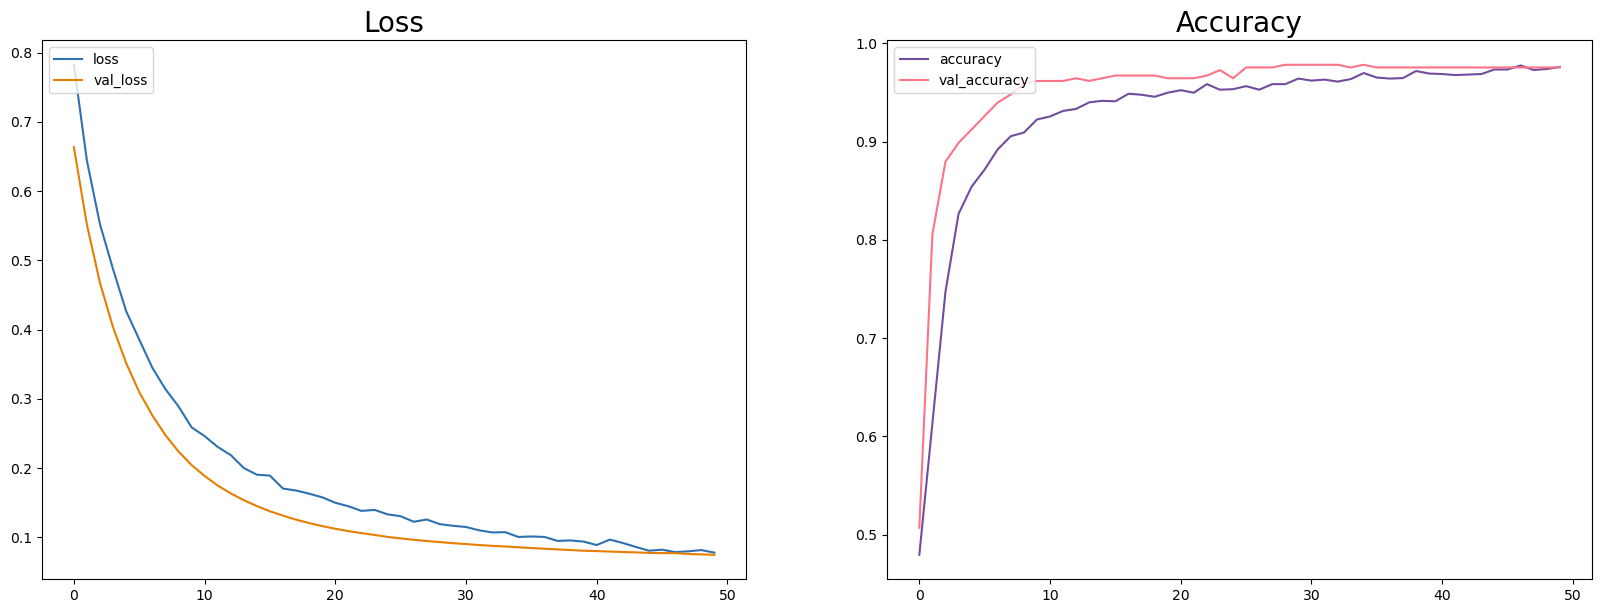

In [15]:
loss_acc_fig(history_mobnet)

In [16]:
ppv_tpr_acc_test(mobnet_model)

2023-07-28 11:23:47.225424: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - 1s 34ms/step


2023-07-28 11:23:48.282130: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - 1s 346ms/step
tf.Tensor(0.984127, shape=(), dtype=float32) tf.Tensor(1.0, shape=(), dtype=float32) tf.Tensor(0.9918033, shape=(), dtype=float32)


2/2 [==============================] - 0s 147ms/step
[[59  1]
 [ 0 62]]


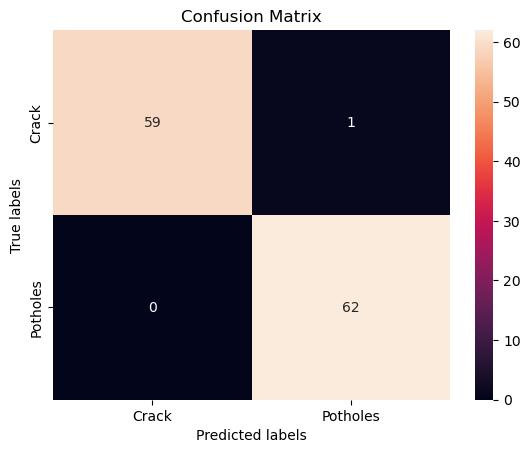

In [17]:
confusion_mat(mobnet_model)

### ResNet152v2

In [18]:
resnet_conv = ResNet152V2(include_top=False, weights='imagenet')

In [19]:
resnet_conv.trainable = False
resnet_conv.summary()

Model: "resnet152v2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, None, None, 3)]      0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, None, None, 3)        0         ['input_2[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, None, None, 64)       9472      ['conv1_pad[0][0]']           
                                                                                                  
 pool1_pad (ZeroPadding2D)   (None, None, None, 64)       0         ['conv1_conv[0][0]']          
                                                                                        

 tchNormalization)                                                                                
                                                                                                  
 conv2_block3_preact_relu (  (None, None, None, 256)      0         ['conv2_block3_preact_bn[0][0]
 Activation)                                                        ']                            
                                                                                                  
 conv2_block3_1_conv (Conv2  (None, None, None, 64)       16384     ['conv2_block3_preact_relu[0][
 D)                                                                 0]']                          
                                                                                                  
 conv2_block3_1_bn (BatchNo  (None, None, None, 64)       256       ['conv2_block3_1_conv[0][0]'] 
 rmalization)                                                                                     
          

 conv3_block2_1_relu (Activ  (None, None, None, 128)      0         ['conv3_block2_1_bn[0][0]']   
 ation)                                                                                           
                                                                                                  
 conv3_block2_2_pad (ZeroPa  (None, None, None, 128)      0         ['conv3_block2_1_relu[0][0]'] 
 dding2D)                                                                                         
                                                                                                  
 conv3_block2_2_conv (Conv2  (None, None, None, 128)      147456    ['conv3_block2_2_pad[0][0]']  
 D)                                                                                               
                                                                                                  
 conv3_block2_2_bn (BatchNo  (None, None, None, 128)      512       ['conv3_block2_2_conv[0][0]'] 
 rmalizati

                                                                                                  
 conv3_block4_out (Add)      (None, None, None, 512)      0         ['conv3_block3_out[0][0]',    
                                                                     'conv3_block4_3_conv[0][0]'] 
                                                                                                  
 conv3_block5_preact_bn (Ba  (None, None, None, 512)      2048      ['conv3_block4_out[0][0]']    
 tchNormalization)                                                                                
                                                                                                  
 conv3_block5_preact_relu (  (None, None, None, 512)      0         ['conv3_block5_preact_bn[0][0]
 Activation)                                                        ']                            
                                                                                                  
 conv3_blo

 ation)                                                                                           
                                                                                                  
 conv3_block7_2_pad (ZeroPa  (None, None, None, 128)      0         ['conv3_block7_1_relu[0][0]'] 
 dding2D)                                                                                         
                                                                                                  
 conv3_block7_2_conv (Conv2  (None, None, None, 128)      147456    ['conv3_block7_2_pad[0][0]']  
 D)                                                                                               
                                                                                                  
 conv3_block7_2_bn (BatchNo  (None, None, None, 128)      512       ['conv3_block7_2_conv[0][0]'] 
 rmalization)                                                                                     
          

 conv4_block1_0_conv (Conv2  (None, None, None, 1024)     525312    ['conv4_block1_preact_relu[0][
 D)                                                                 0]']                          
                                                                                                  
 conv4_block1_3_conv (Conv2  (None, None, None, 1024)     263168    ['conv4_block1_2_relu[0][0]'] 
 D)                                                                                               
                                                                                                  
 conv4_block1_out (Add)      (None, None, None, 1024)     0         ['conv4_block1_0_conv[0][0]', 
                                                                     'conv4_block1_3_conv[0][0]'] 
                                                                                                  
 conv4_block2_preact_bn (Ba  (None, None, None, 1024)     4096      ['conv4_block1_out[0][0]']    
 tchNormal

                                                                                                  
 conv4_block4_1_bn (BatchNo  (None, None, None, 256)      1024      ['conv4_block4_1_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv4_block4_1_relu (Activ  (None, None, None, 256)      0         ['conv4_block4_1_bn[0][0]']   
 ation)                                                                                           
                                                                                                  
 conv4_block4_2_pad (ZeroPa  (None, None, None, 256)      0         ['conv4_block4_1_relu[0][0]'] 
 dding2D)                                                                                         
                                                                                                  
 conv4_blo

 ation)                                                                                           
                                                                                                  
 conv4_block6_3_conv (Conv2  (None, None, None, 1024)     263168    ['conv4_block6_2_relu[0][0]'] 
 D)                                                                                               
                                                                                                  
 conv4_block6_out (Add)      (None, None, None, 1024)     0         ['conv4_block5_out[0][0]',    
                                                                     'conv4_block6_3_conv[0][0]'] 
                                                                                                  
 conv4_block7_preact_bn (Ba  (None, None, None, 1024)     4096      ['conv4_block6_out[0][0]']    
 tchNormalization)                                                                                
          

 conv4_block9_1_bn (BatchNo  (None, None, None, 256)      1024      ['conv4_block9_1_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv4_block9_1_relu (Activ  (None, None, None, 256)      0         ['conv4_block9_1_bn[0][0]']   
 ation)                                                                                           
                                                                                                  
 conv4_block9_2_pad (ZeroPa  (None, None, None, 256)      0         ['conv4_block9_1_relu[0][0]'] 
 dding2D)                                                                                         
                                                                                                  
 conv4_block9_2_conv (Conv2  (None, None, None, 256)      589824    ['conv4_block9_2_pad[0][0]']  
 D)       

                                                                                                  
 conv4_block11_3_conv (Conv  (None, None, None, 1024)     263168    ['conv4_block11_2_relu[0][0]']
 2D)                                                                                              
                                                                                                  
 conv4_block11_out (Add)     (None, None, None, 1024)     0         ['conv4_block10_out[0][0]',   
                                                                     'conv4_block11_3_conv[0][0]']
                                                                                                  
 conv4_block12_preact_bn (B  (None, None, None, 1024)     4096      ['conv4_block11_out[0][0]']   
 atchNormalization)                                                                               
                                                                                                  
 conv4_blo

 ormalization)                                                                                    
                                                                                                  
 conv4_block14_1_relu (Acti  (None, None, None, 256)      0         ['conv4_block14_1_bn[0][0]']  
 vation)                                                                                          
                                                                                                  
 conv4_block14_2_pad (ZeroP  (None, None, None, 256)      0         ['conv4_block14_1_relu[0][0]']
 adding2D)                                                                                        
                                                                                                  
 conv4_block14_2_conv (Conv  (None, None, None, 256)      589824    ['conv4_block14_2_pad[0][0]'] 
 2D)                                                                                              
          

 conv4_block16_3_conv (Conv  (None, None, None, 1024)     263168    ['conv4_block16_2_relu[0][0]']
 2D)                                                                                              
                                                                                                  
 conv4_block16_out (Add)     (None, None, None, 1024)     0         ['conv4_block15_out[0][0]',   
                                                                     'conv4_block16_3_conv[0][0]']
                                                                                                  
 conv4_block17_preact_bn (B  (None, None, None, 1024)     4096      ['conv4_block16_out[0][0]']   
 atchNormalization)                                                                               
                                                                                                  
 conv4_block17_preact_relu   (None, None, None, 1024)     0         ['conv4_block17_preact_bn[0][0
 (Activati

                                                                                                  
 conv4_block19_1_relu (Acti  (None, None, None, 256)      0         ['conv4_block19_1_bn[0][0]']  
 vation)                                                                                          
                                                                                                  
 conv4_block19_2_pad (ZeroP  (None, None, None, 256)      0         ['conv4_block19_1_relu[0][0]']
 adding2D)                                                                                        
                                                                                                  
 conv4_block19_2_conv (Conv  (None, None, None, 256)      589824    ['conv4_block19_2_pad[0][0]'] 
 2D)                                                                                              
                                                                                                  
 conv4_blo

 2D)                                                                                              
                                                                                                  
 conv4_block21_out (Add)     (None, None, None, 1024)     0         ['conv4_block20_out[0][0]',   
                                                                     'conv4_block21_3_conv[0][0]']
                                                                                                  
 conv4_block22_preact_bn (B  (None, None, None, 1024)     4096      ['conv4_block21_out[0][0]']   
 atchNormalization)                                                                               
                                                                                                  
 conv4_block22_preact_relu   (None, None, None, 1024)     0         ['conv4_block22_preact_bn[0][0
 (Activation)                                                       ]']                           
          

 conv4_block24_1_relu (Acti  (None, None, None, 256)      0         ['conv4_block24_1_bn[0][0]']  
 vation)                                                                                          
                                                                                                  
 conv4_block24_2_pad (ZeroP  (None, None, None, 256)      0         ['conv4_block24_1_relu[0][0]']
 adding2D)                                                                                        
                                                                                                  
 conv4_block24_2_conv (Conv  (None, None, None, 256)      589824    ['conv4_block24_2_pad[0][0]'] 
 2D)                                                                                              
                                                                                                  
 conv4_block24_2_bn (BatchN  (None, None, None, 256)      1024      ['conv4_block24_2_conv[0][0]']
 ormalizat

                                                                                                  
 conv4_block26_out (Add)     (None, None, None, 1024)     0         ['conv4_block25_out[0][0]',   
                                                                     'conv4_block26_3_conv[0][0]']
                                                                                                  
 conv4_block27_preact_bn (B  (None, None, None, 1024)     4096      ['conv4_block26_out[0][0]']   
 atchNormalization)                                                                               
                                                                                                  
 conv4_block27_preact_relu   (None, None, None, 1024)     0         ['conv4_block27_preact_bn[0][0
 (Activation)                                                       ]']                           
                                                                                                  
 conv4_blo

 vation)                                                                                          
                                                                                                  
 conv4_block29_2_pad (ZeroP  (None, None, None, 256)      0         ['conv4_block29_1_relu[0][0]']
 adding2D)                                                                                        
                                                                                                  
 conv4_block29_2_conv (Conv  (None, None, None, 256)      589824    ['conv4_block29_2_pad[0][0]'] 
 2D)                                                                                              
                                                                                                  
 conv4_block29_2_bn (BatchN  (None, None, None, 256)      1024      ['conv4_block29_2_conv[0][0]']
 ormalization)                                                                                    
          

 conv4_block31_out (Add)     (None, None, None, 1024)     0         ['conv4_block30_out[0][0]',   
                                                                     'conv4_block31_3_conv[0][0]']
                                                                                                  
 conv4_block32_preact_bn (B  (None, None, None, 1024)     4096      ['conv4_block31_out[0][0]']   
 atchNormalization)                                                                               
                                                                                                  
 conv4_block32_preact_relu   (None, None, None, 1024)     0         ['conv4_block32_preact_bn[0][0
 (Activation)                                                       ]']                           
                                                                                                  
 conv4_block32_1_conv (Conv  (None, None, None, 256)      262144    ['conv4_block32_preact_relu[0]
 2D)      

                                                                                                  
 conv4_block34_2_pad (ZeroP  (None, None, None, 256)      0         ['conv4_block34_1_relu[0][0]']
 adding2D)                                                                                        
                                                                                                  
 conv4_block34_2_conv (Conv  (None, None, None, 256)      589824    ['conv4_block34_2_pad[0][0]'] 
 2D)                                                                                              
                                                                                                  
 conv4_block34_2_bn (BatchN  (None, None, None, 256)      1024      ['conv4_block34_2_conv[0][0]']
 ormalization)                                                                                    
                                                                                                  
 conv4_blo

 2D)                                                                                              
                                                                                                  
 conv4_block36_out (Add)     (None, None, None, 1024)     0         ['max_pooling2d_2[0][0]',     
                                                                     'conv4_block36_3_conv[0][0]']
                                                                                                  
 conv5_block1_preact_bn (Ba  (None, None, None, 1024)     4096      ['conv4_block36_out[0][0]']   
 tchNormalization)                                                                                
                                                                                                  
 conv5_block1_preact_relu (  (None, None, None, 1024)     0         ['conv5_block1_preact_bn[0][0]
 Activation)                                                        ']                            
          

 conv5_block3_1_bn (BatchNo  (None, None, None, 512)      2048      ['conv5_block3_1_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv5_block3_1_relu (Activ  (None, None, None, 512)      0         ['conv5_block3_1_bn[0][0]']   
 ation)                                                                                           
                                                                                                  
 conv5_block3_2_pad (ZeroPa  (None, None, None, 512)      0         ['conv5_block3_1_relu[0][0]'] 
 dding2D)                                                                                         
                                                                                                  
 conv5_block3_2_conv (Conv2  (None, None, None, 512)      2359296   ['conv5_block3_2_pad[0][0]']  
 D)       

In [20]:
resnet_model = Sequential()

resnet_model.add(resnet_conv)
resnet_model.add(GlobalAveragePooling2D())
resnet_model.add(Dense(256, activation = 'relu'))
resnet_model.add(Dropout(0.2))
resnet_model.add(Dense(128, activation = 'relu'))
resnet_model.add(Dropout(0.2))
resnet_model.add(Dense(1, activation = 'sigmoid'))

resnet_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet152v2 (Functional)    (None, None, None, 2048   58331648  
                             )                                   
                                                                 
 global_average_pooling2d_1  (None, 2048)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_3 (Dense)             (None, 256)               524544    
                                                                 
 dropout_2 (Dropout)         (None, 256)               0         
                                                                 
 dense_4 (Dense)             (None, 128)               32896     
                                                                 
 dropout_3 (Dropout)         (None, 128)              

In [21]:
resnet_model.compile(optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=0.00002),
                     loss=tf.losses.BinaryCrossentropy(),
                     metrics=['accuracy'])

In [22]:
history_resnet = resnet_model.fit(train, epochs=60, validation_data=dev, callbacks=[tensorboard_callback, earlystop_callback])

Epoch 1/60


2023-07-28 11:24:26.162971: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


31/31 [==============================] - ETA: 0s - loss: 0.6912 - accuracy: 0.5807

2023-07-28 11:25:14.150804: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


31/31 [==============================] - 64s 2s/step - loss: 0.6912 - accuracy: 0.5807 - val_loss: 0.5443 - val_accuracy: 0.7863
Epoch 2/60
31/31 [==============================] - 54s 2s/step - loss: 0.5377 - accuracy: 0.7528 - val_loss: 0.4300 - val_accuracy: 0.8986
Epoch 3/60
31/31 [==============================] - 54s 2s/step - loss: 0.4410 - accuracy: 0.8361 - val_loss: 0.3626 - val_accuracy: 0.9123
Epoch 4/60
31/31 [==============================] - 54s 2s/step - loss: 0.3960 - accuracy: 0.8566 - val_loss: 0.3194 - val_accuracy: 0.9205
Epoch 5/60
31/31 [==============================] - 53s 2s/step - loss: 0.3498 - accuracy: 0.8818 - val_loss: 0.2884 - val_accuracy: 0.9233
Epoch 6/60
31/31 [==============================] - 54s 2s/step - loss: 0.3144 - accuracy: 0.8998 - val_loss: 0.2649 - val_accuracy: 0.9233
Epoch 7/60
31/31 [==============================] - 60s 2s/step - loss: 0.2953 - accuracy: 0.9065 - val_loss: 0.2454 - val_accuracy: 0.9315
Epoch 8/60
31/31 [=============

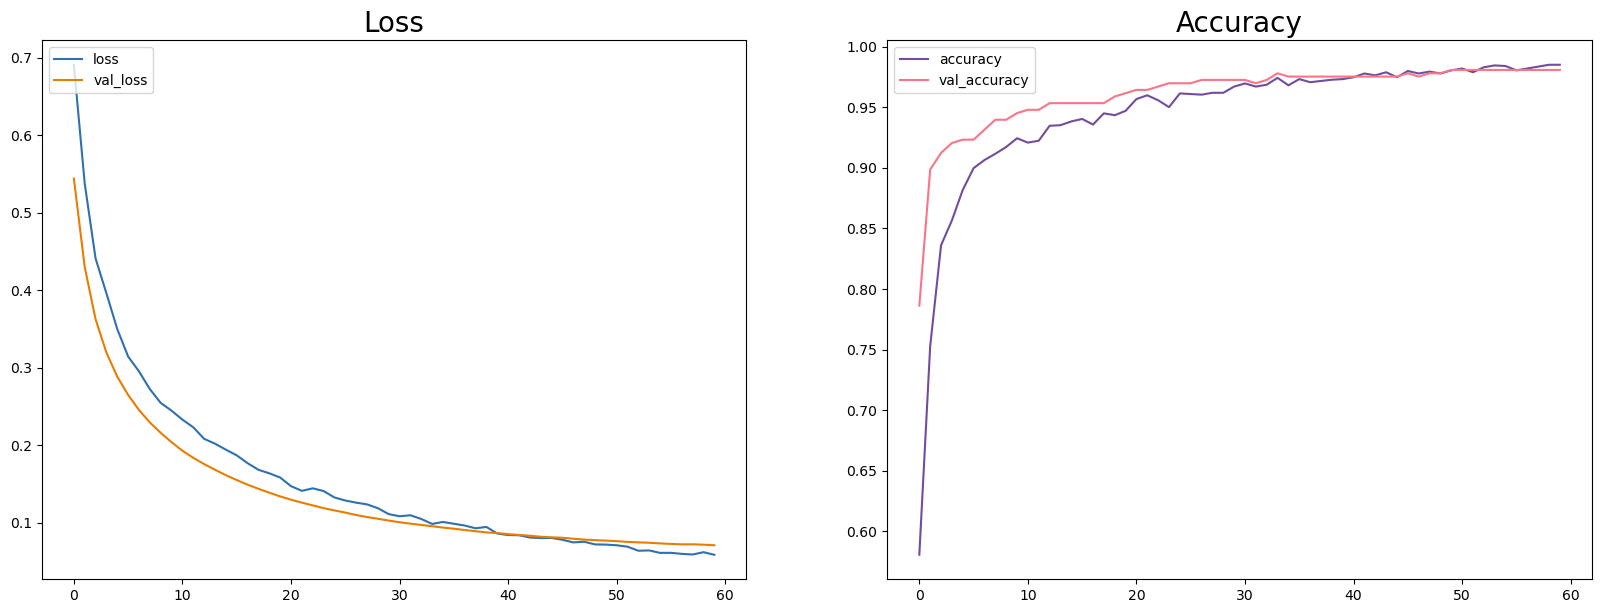

In [23]:
loss_acc_fig(history_resnet)

In [24]:
ppv_tpr_acc_test(resnet_model)

2023-07-28 12:23:30.911837: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - 4s 566ms/step


2023-07-28 12:23:35.046511: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - 6s 2s/step
tf.Tensor(0.984127, shape=(), dtype=float32) tf.Tensor(1.0, shape=(), dtype=float32) tf.Tensor(0.9918033, shape=(), dtype=float32)


2/2 [==============================] - 2s 787ms/step
[[59  1]
 [ 0 62]]


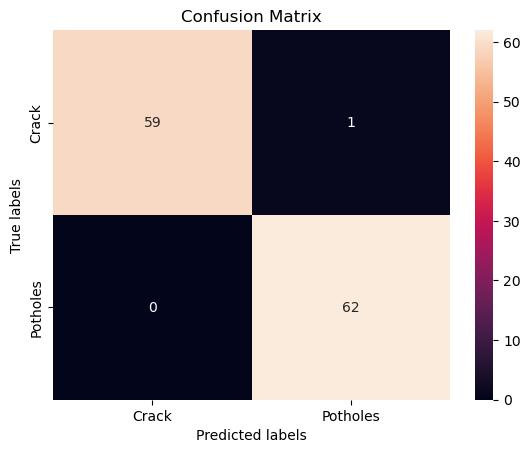

In [25]:
confusion_mat(resnet_model)

### Inceptionv3

In [7]:
incept_conv = InceptionV3(weights = 'imagenet', include_top = False, input_shape=(224,224,3))

In [8]:
incept_conv.trainable = False
incept_conv.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 111, 111, 32)         864       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 111, 111, 32)         96        ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 111, 111, 32)         0         ['batch_normalizati

 conv2d_11 (Conv2D)          (None, 25, 25, 32)           6144      ['average_pooling2d[0][0]']   
                                                                                                  
 batch_normalization_5 (Bat  (None, 25, 25, 64)           192       ['conv2d_5[0][0]']            
 chNormalization)                                                                                 
                                                                                                  
 batch_normalization_7 (Bat  (None, 25, 25, 64)           192       ['conv2d_7[0][0]']            
 chNormalization)                                                                                 
                                                                                                  
 batch_normalization_10 (Ba  (None, 25, 25, 96)           288       ['conv2d_10[0][0]']           
 tchNormalization)                                                                                
          

                                                                                                  
 activation_17 (Activation)  (None, 25, 25, 96)           0         ['batch_normalization_17[0][0]
                                                                    ']                            
                                                                                                  
 activation_18 (Activation)  (None, 25, 25, 64)           0         ['batch_normalization_18[0][0]
                                                                    ']                            
                                                                                                  
 mixed1 (Concatenate)        (None, 25, 25, 288)          0         ['activation_12[0][0]',       
                                                                     'activation_14[0][0]',       
                                                                     'activation_17[0][0]',       
          

                                                                                                  
 conv2d_28 (Conv2D)          (None, 25, 25, 96)           55296     ['activation_27[0][0]']       
                                                                                                  
 batch_normalization_28 (Ba  (None, 25, 25, 96)           288       ['conv2d_28[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 activation_28 (Activation)  (None, 25, 25, 96)           0         ['batch_normalization_28[0][0]
                                                                    ']                            
                                                                                                  
 conv2d_26 (Conv2D)          (None, 12, 12, 384)          995328    ['mixed2[0][0]']              
          

 conv2d_30 (Conv2D)          (None, 12, 12, 192)          147456    ['mixed3[0][0]']              
                                                                                                  
 conv2d_33 (Conv2D)          (None, 12, 12, 192)          172032    ['activation_32[0][0]']       
                                                                                                  
 conv2d_38 (Conv2D)          (None, 12, 12, 192)          172032    ['activation_37[0][0]']       
                                                                                                  
 conv2d_39 (Conv2D)          (None, 12, 12, 192)          147456    ['average_pooling2d_3[0][0]'] 
                                                                                                  
 batch_normalization_30 (Ba  (None, 12, 12, 192)          576       ['conv2d_30[0][0]']           
 tchNormalization)                                                                                
          

                                                                    ']                            
                                                                                                  
 average_pooling2d_4 (Avera  (None, 12, 12, 768)          0         ['mixed4[0][0]']              
 gePooling2D)                                                                                     
                                                                                                  
 conv2d_40 (Conv2D)          (None, 12, 12, 192)          147456    ['mixed4[0][0]']              
                                                                                                  
 conv2d_43 (Conv2D)          (None, 12, 12, 192)          215040    ['activation_42[0][0]']       
                                                                                                  
 conv2d_48 (Conv2D)          (None, 12, 12, 192)          215040    ['activation_47[0][0]']       
          

                                                                                                  
 activation_52 (Activation)  (None, 12, 12, 160)          0         ['batch_normalization_52[0][0]
                                                                    ']                            
                                                                                                  
 activation_57 (Activation)  (None, 12, 12, 160)          0         ['batch_normalization_57[0][0]
                                                                    ']                            
                                                                                                  
 average_pooling2d_5 (Avera  (None, 12, 12, 768)          0         ['mixed5[0][0]']              
 gePooling2D)                                                                                     
                                                                                                  
 conv2d_50

 batch_normalization_62 (Ba  (None, 12, 12, 192)          576       ['conv2d_62[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 batch_normalization_67 (Ba  (None, 12, 12, 192)          576       ['conv2d_67[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 activation_62 (Activation)  (None, 12, 12, 192)          0         ['batch_normalization_62[0][0]
                                                                    ']                            
                                                                                                  
 activation_67 (Activation)  (None, 12, 12, 192)          0         ['batch_normalization_67[0][0]
          

                                                                                                  
 conv2d_71 (Conv2D)          (None, 5, 5, 320)            552960    ['activation_70[0][0]']       
                                                                                                  
 conv2d_75 (Conv2D)          (None, 5, 5, 192)            331776    ['activation_74[0][0]']       
                                                                                                  
 batch_normalization_71 (Ba  (None, 5, 5, 320)            960       ['conv2d_71[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 batch_normalization_75 (Ba  (None, 5, 5, 192)            576       ['conv2d_75[0][0]']           
 tchNormalization)                                                                                
          

                                                                                                  
 activation_82 (Activation)  (None, 5, 5, 384)            0         ['batch_normalization_82[0][0]
                                                                    ']                            
                                                                                                  
 activation_83 (Activation)  (None, 5, 5, 384)            0         ['batch_normalization_83[0][0]
                                                                    ']                            
                                                                                                  
 batch_normalization_84 (Ba  (None, 5, 5, 192)            576       ['conv2d_84[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 activatio

                                                                                                  
 activation_88 (Activation)  (None, 5, 5, 384)            0         ['batch_normalization_88[0][0]
                                                                    ']                            
                                                                                                  
 activation_91 (Activation)  (None, 5, 5, 384)            0         ['batch_normalization_91[0][0]
                                                                    ']                            
                                                                                                  
 activation_92 (Activation)  (None, 5, 5, 384)            0         ['batch_normalization_92[0][0]
                                                                    ']                            
                                                                                                  
 batch_nor

In [16]:
incept_model = Sequential()

incept_model.add(incept_conv)
incept_model.add(GlobalAveragePooling2D())
incept_model.add(Dense(256, activation = 'relu'))
incept_model.add(Dropout(0.3))
incept_model.add(Dense(128, activation = 'relu'))
incept_model.add(Dropout(0.3))
incept_model.add(Dense(1, activation = 'sigmoid'))

incept_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 5, 5, 2048)        21802784  
                                                                 
 global_average_pooling2d_1  (None, 2048)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_3 (Dense)             (None, 256)               524544    
                                                                 
 dropout_2 (Dropout)         (None, 256)               0         
                                                                 
 dense_4 (Dense)             (None, 128)               32896     
                                                                 
 dropout_3 (Dropout)         (None, 128)               0         
                                                      

In [17]:
incept_model.compile(optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=0.00002),
                     loss=tf.losses.BinaryCrossentropy(),
                     metrics=['accuracy'])

In [18]:
history_incept = incept_model.fit(train, epochs=40, validation_data=dev, callbacks=[tensorboard_callback, earlystop_callback])

Epoch 1/40


2023-08-03 14:48:06.182132: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


31/31 [==============================] - ETA: 0s - loss: 0.5704 - accuracy: 0.6942

2023-08-03 14:48:22.049886: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


31/31 [==============================] - 23s 589ms/step - loss: 0.5704 - accuracy: 0.6942 - val_loss: 0.3855 - val_accuracy: 0.8575
Epoch 2/40
31/31 [==============================] - 17s 480ms/step - loss: 0.4015 - accuracy: 0.8222 - val_loss: 0.3001 - val_accuracy: 0.8685
Epoch 3/40
31/31 [==============================] - 17s 482ms/step - loss: 0.3427 - accuracy: 0.8582 - val_loss: 0.2557 - val_accuracy: 0.9041
Epoch 4/40
31/31 [==============================] - 17s 471ms/step - loss: 0.2998 - accuracy: 0.8762 - val_loss: 0.2238 - val_accuracy: 0.9288
Epoch 5/40
31/31 [==============================] - 17s 470ms/step - loss: 0.2594 - accuracy: 0.9126 - val_loss: 0.1985 - val_accuracy: 0.9452
Epoch 6/40
31/31 [==============================] - 17s 469ms/step - loss: 0.2425 - accuracy: 0.9106 - val_loss: 0.1801 - val_accuracy: 0.9534
Epoch 7/40
31/31 [==============================] - 17s 470ms/step - loss: 0.2244 - accuracy: 0.9178 - val_loss: 0.1670 - val_accuracy: 0.9507
Epoch 8/40

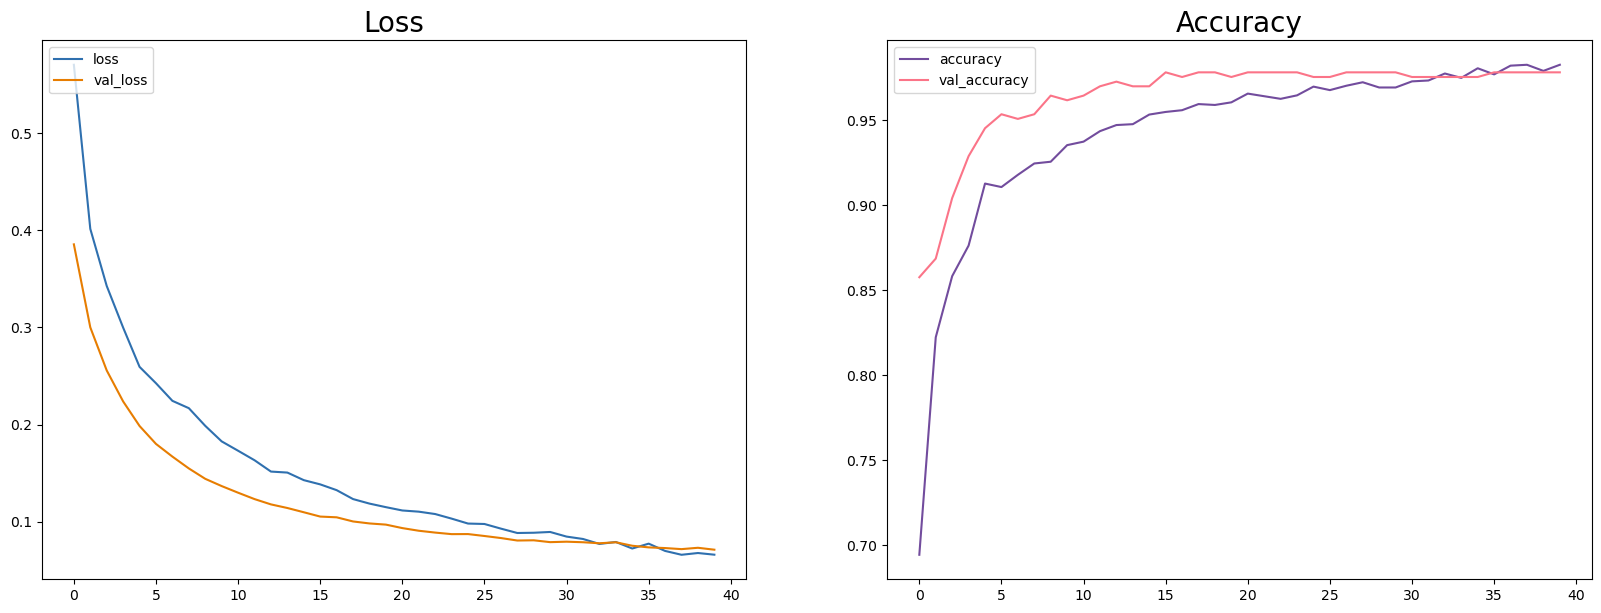

In [19]:
loss_acc_fig(history_incept)

In [20]:
ppv_tpr_acc_test(incept_model)

2023-08-03 15:00:28.499738: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - 2s 46ms/step


2023-08-03 15:00:30.490043: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - 2s 877ms/step
tf.Tensor(0.9677419, shape=(), dtype=float32) tf.Tensor(0.9677419, shape=(), dtype=float32) tf.Tensor(0.9672131, shape=(), dtype=float32)


2/2 [==============================] - 0s 192ms/step
[[58  2]
 [ 2 60]]


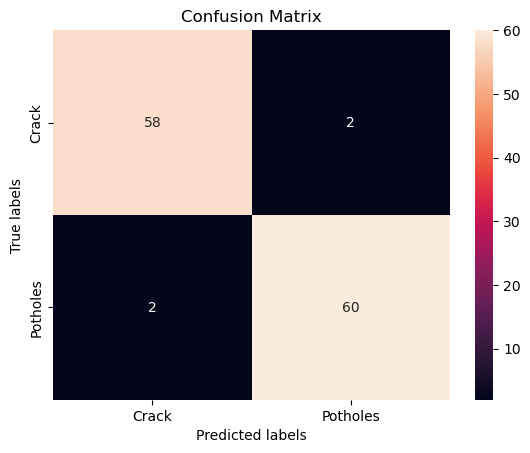

In [21]:
confusion_mat(incept_model)

### VGG16

In [22]:
vgg_conv = VGG16(weights = 'imagenet', include_top = False)

In [23]:
vgg_conv.trainable = False
vgg_conv.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

In [30]:
vgg_model = Sequential()

vgg_model.add(vgg_conv)

vgg_model.add(GlobalAveragePooling2D())
vgg_model.add(Dense(256, activation = 'relu'))
vgg_model.add(Dropout(0.2))
vgg_model.add(Dense(128, activation = 'relu'))
vgg_model.add(Dropout(0.2))
vgg_model.add(Dense(1, activation = 'sigmoid'))

vgg_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, None, None, 512)   14714688  
                                                                 
 global_average_pooling2d_3  (None, 512)               0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_9 (Dense)             (None, 256)               131328    
                                                                 
 dropout_6 (Dropout)         (None, 256)               0         
                                                                 
 dense_10 (Dense)            (None, 128)               32896     
                                                                 
 dropout_7 (Dropout)         (None, 128)               0         
                                                      

In [34]:
vgg_model.compile(optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=0.00002),
                  loss=tf.losses.BinaryCrossentropy(),
                  metrics=['accuracy'])

In [71]:
history_vgg = vgg_model.fit(train, epochs=5, validation_data=dev, callbacks=[tensorboard_callback, earlystop_callback])

Epoch 1/5
31/31 [==============================] - 45s 1s/step - loss: 0.1191 - accuracy: 0.9604 - val_loss: 0.1173 - val_accuracy: 0.9589
Epoch 2/5
31/31 [==============================] - 45s 1s/step - loss: 0.1178 - accuracy: 0.9599 - val_loss: 0.1178 - val_accuracy: 0.9616
Epoch 3/5
31/31 [==============================] - 45s 1s/step - loss: 0.1167 - accuracy: 0.9599 - val_loss: 0.1167 - val_accuracy: 0.9562
Epoch 4/5
31/31 [==============================] - 45s 1s/step - loss: 0.1141 - accuracy: 0.9615 - val_loss: 0.1170 - val_accuracy: 0.9589
Epoch 5/5
31/31 [==============================] - 45s 1s/step - loss: 0.1148 - accuracy: 0.9609 - val_loss: 0.1162 - val_accuracy: 0.9562


In [ ]:
loss_acc_fig(history_vgg)

In [73]:
ppv_tpr_acc_test(vgg_model)

2/2 [==============================] - 1s 600ms/step
tf.Tensor(0.95384616, shape=(), dtype=float32) tf.Tensor(1.0, shape=(), dtype=float32) tf.Tensor(0.97540987, shape=(), dtype=float32)


2/2 [==============================] - 1s 564ms/step
[[57  3]
 [ 0 62]]


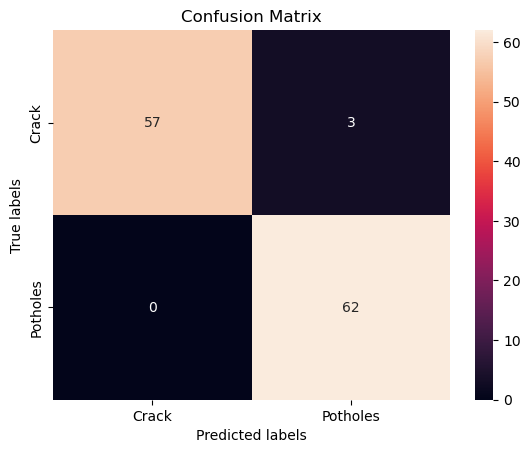

In [74]:
confusion_mat(vgg_model)

In [ ]:
mobnet_model.save(os.path.join('models','MobNet_model.h5'))
resnet_model.save(os.path.join('models','ResNet_model.h5'))
incept_model.save(os.path.join('models','Inception_model.h5'))
vgg_model.save(os.path.join('models', 'VGG_model.h5'))